In [ ]:
pip install tensorflow

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [66]:
### Trabajar con el dataset original preprocesado para eliminar ruido, nulos y duplicados
df = pd.read_csv('../data/sin_nulos_ventana_2_dias.csv')

# print(df.keys())

# Eliminar las filas con valores faltantes, si las hay
df.dropna(inplace=True)

# Convertir las columnas categóricas a numéricas
encoder = LabelEncoder()
df['RainToday'] = encoder.fit_transform(df['RainToday'])
df['RainTomorrow'] = encoder.fit_transform(df['RainTomorrow'])
df['RainYesterday'] = encoder.fit_transform(df['RainYesterday'])
df['Rain2daysAgo'] = encoder.fit_transform(df['Rain2daysAgo'])

# Seleccionar las características y la columna objetivo
X = df.drop(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir9am', 'WindDir3pm', 'RainTomorrow'], axis=1)
y = df['RainTomorrow']

# Escalar los datos para normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# -----------------------------------------------------------------
numComponents_initial = df.select_dtypes('float64').shape[1]
num_data = df.select_dtypes('float64')

data_transformed_ = (num_data-num_data.min())/(num_data.max()-num_data.min())
X_train, X_test, y_train, y_test = train_test_split(df.select_dtypes('float64'),df['RainTomorrow'], test_size=0.30, random_state=42)
for numComponents in range(numComponents_initial):
    pca = PCA(n_components=numComponents)
    pca.fit(X_train.to_numpy())
    if pca.explained_variance_ratio_.sum()>=0.998:
        break 
projected_train = pca.transform(X_train.to_numpy())
projected_train = pd.DataFrame(projected_train)

projected_test = pca.transform(X_test.to_numpy())
projected_test = pd.DataFrame(projected_test)

X_train=projected_train
X_test=projected_test
# -----------------------------------------------------------------

# Convertir la variable objetivo a formato categórico (si es necesario)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Crear el modelo de red neuronal
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))  # Capa de salida con 2 neuronas para clasificación binaria
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/20
1542/1542 [==============================] - 3s 2ms/step - loss: 0.4632 - accuracy: 0.8224 - val_loss: 0.3476 - val_accuracy: 0.8501
Epoch 2/20
1542/1542 [==============================] - 3s 2ms/step - loss: 0.3597 - accuracy: 0.8447 - val_loss: 0.3410 - val_accuracy: 0.8501
Epoch 3/20
1542/1542 [==============================] - 3s 2ms/step - loss: 0.3528 - accuracy: 0.8456 - val_loss: 0.3339 - val_accuracy: 0.8529
Epoch 4/20
1542/1542 [==============================] - 3s 2ms/step - loss: 0.3489 - accuracy: 0.8484 - val_loss: 0.3381 - val_accuracy: 0.8553
Epoch 5/20
1542/1542 [==============================] - 3s 2ms/step - loss: 0.3469 - accuracy: 0.8496 - val_loss: 0.3359 - val_accuracy: 0.8534
Epoch 6/20
1542/1542 [==============================] - 3s 2ms/step - loss: 0.3442 - accuracy: 0.8507 - val_loss: 0.3377 - val_accuracy: 0.8537
Epoch 7/20
1542/1542 [==============================] - 3s 2ms/step - loss: 0.3448 - accuracy: 0.8510 - val_loss: 0.3352 - val_accuracy:

In [67]:
# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred[:, 1]]  # Convertir las predicciones a clases binarias


661/661 [==============================] - 1s 981us/step


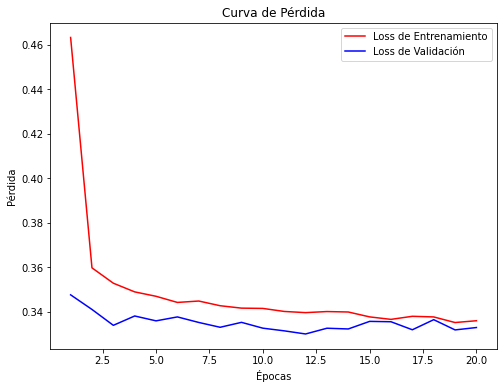

In [68]:
# Obtener la pérdida en el conjunto de entrenamiento y prueba
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de la curva de pérdida
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'r', label='Loss de Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Loss de Validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

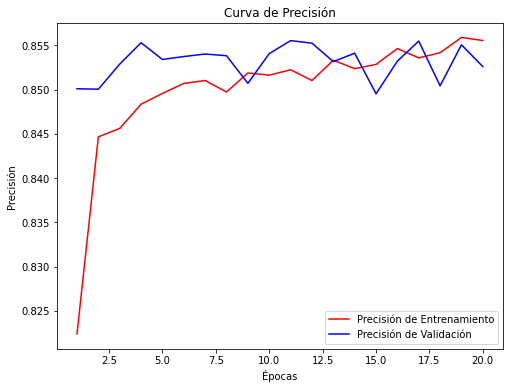

In [69]:
# Obtener la precisión en el conjunto de entrenamiento y prueba
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear un gráfico de la curva de precisión
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, 'r', label='Precisión de Entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de Validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

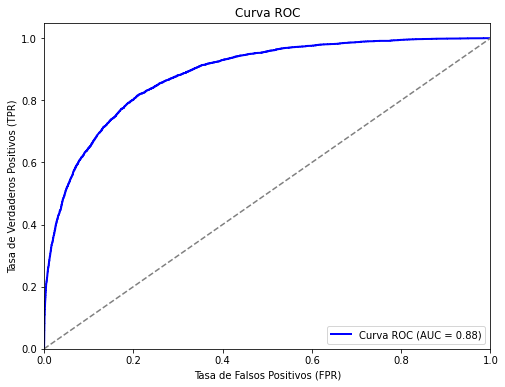

In [70]:
# Obtener las probabilidades de predicción para la clase positiva
y_pred_probs = y_pred[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

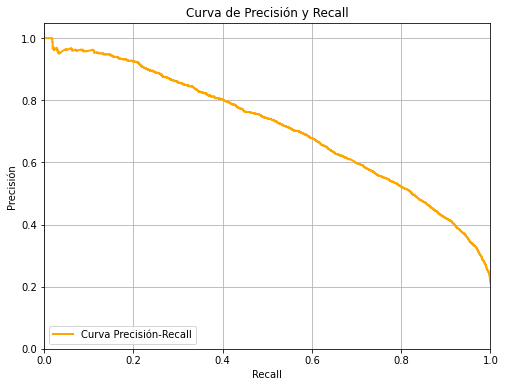

In [71]:
from sklearn.metrics import precision_recall_curve

# Calcular la precisión y el recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Graficar la curva de precisión y recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='orange', lw=2, label='Curva Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión y Recall')
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

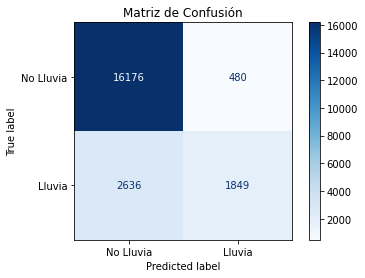

In [72]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Mostrar la matriz de confusión utilizando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Lluvia', 'Lluvia'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

In [73]:
# Obtener el reporte de clasificación por clase
class_report = classification_report(y_test, y_pred_classes)
print("\nReporte de Clasificación por Clase:")
print(class_report)

kappa_score = cohen_kappa_score(y_test, y_pred_classes)

print("\nKappa Score:")
print(kappa_score)


Reporte de Clasificación por Clase:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     16656
           1       0.79      0.41      0.54      4485

    accuracy                           0.85     21141
   macro avg       0.83      0.69      0.73     21141
weighted avg       0.85      0.85      0.83     21141


Kappa Score:
0.465139599149892
